# Plotting Newspaper Data
An example of how to use the eLuxemburgensia digital collection and plotting to visually display data.

This project uses Jupyter Notebooks to encapsulate all information regarding the project. The notebook requests a date range from the user. It then uses those dates to select a list of newspapers published during that time period. The newspapers are then plotted showing their publishing density over time.

## Requirements
* Python 3.12
* [requests](https://pypi.org/project/requests/): HTTP library to run HTTP requests
* [pandas](https://pandas.pydata.org/): format the output into tabular layout that can be read by seaborn to plot the data
* [matplotlib](https://matplotlib.org/): customising the plot - figure size, title, etc.
* [seaborn](https://seaborn.pydata.org/index.html): plotting the newspaper density

In [1]:
%pip install requests
%pip install pandas
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from datetime import datetime
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
# Request the start date from the user   
while (True):
    input_date = input("Enter the start date (dd/mm/yyyy):")
    try:
        start_date_value = datetime.strptime(input_date,'%d/%m/%Y')
        break
    except:
        print("Please enter a valid date in the format dd/mm/yyyy.")
        

Enter the start date (dd/mm/yyyy): 28/07/1914


In [4]:
# Request the end date from the user
while (True):
    input_date = input("Enter the end date (dd/mm/yyyy):")
    try:
        end_date_value = datetime.strptime(input_date,'%d/%m/%Y')
        break
    except:
        print("Please enter a valid date in the format dd/mm/yyyy.")

Enter the end date (dd/mm/yyyy): 11/11/1918


In [5]:
# get the BnL eluxembourgensia collection
elux_collection = requests.get("https://viewer.eluxemburgensia.lu/api/viewer2/cms/v2/digitalcollections")
elux_collection = elux_collection.json()

In [13]:
for newspaper in elux_collection["data"]:
    newspaper_start_date = ""
    newspaper_end_date = ""
    newspaper_end_date_print = ""
    newspaper_paperid = newspaper["paperid"]
    newspaper_start_date = newspaper["startdate"]
    try:
        newspaper_end_date = newspaper["enddate"]
        newspaper_end_date_print = newspaper_end_date
    except:
        # if no end date, we set the end date to 9999-12-31 in order to be able to easily compare the dates
        newspaper_end_date = "9999-12-31"
        # but we don't want to print 9999-12-31 so we set the print end date to an empty string
        newspaper_end_date_print = ""

    # check that newspaper start and end date falls within the specified period    
    if newspaper_start_date <= end_date_value.strftime("%Y-%m-%d") and newspaper_end_date >= start_date_value.strftime("%Y-%m-%d"):
        newspaper_countbyyear_result = requests.get("https://viewer.eluxemburgensia.lu/api/viewer2/collections/" + newspaper_paperid + "/countByYear")
        newspaper_countbyyear = newspaper_countbyyear_result.json()
        # if the api returned data for the given paperid, then store it in the list of chosen newspapers
        # and concatenate the count by year data that will be used for plotting
        if newspaper_countbyyear["status"] == "OK":
            # only keep data for the years we are interested in
            countbyyear_data = {}
            for data_entry in newspaper_countbyyear["data"]:
                if data_entry["year"] >= start_date_value.year and data_entry["year"] <= end_date_value.year:
                    countbyyear_data.update({data_entry["year"]:data_entry["n"]})

            # if nothing in the count by year data then skip this newspaper and move to the next one.
            # this shouldn't happen since we've already checked that the newspaper was published during our selected time frame.
            if len(countbyyear_data) == 0:
                continue

            newspaper_dict.update({newspaper["title"]:countbyyear_data})

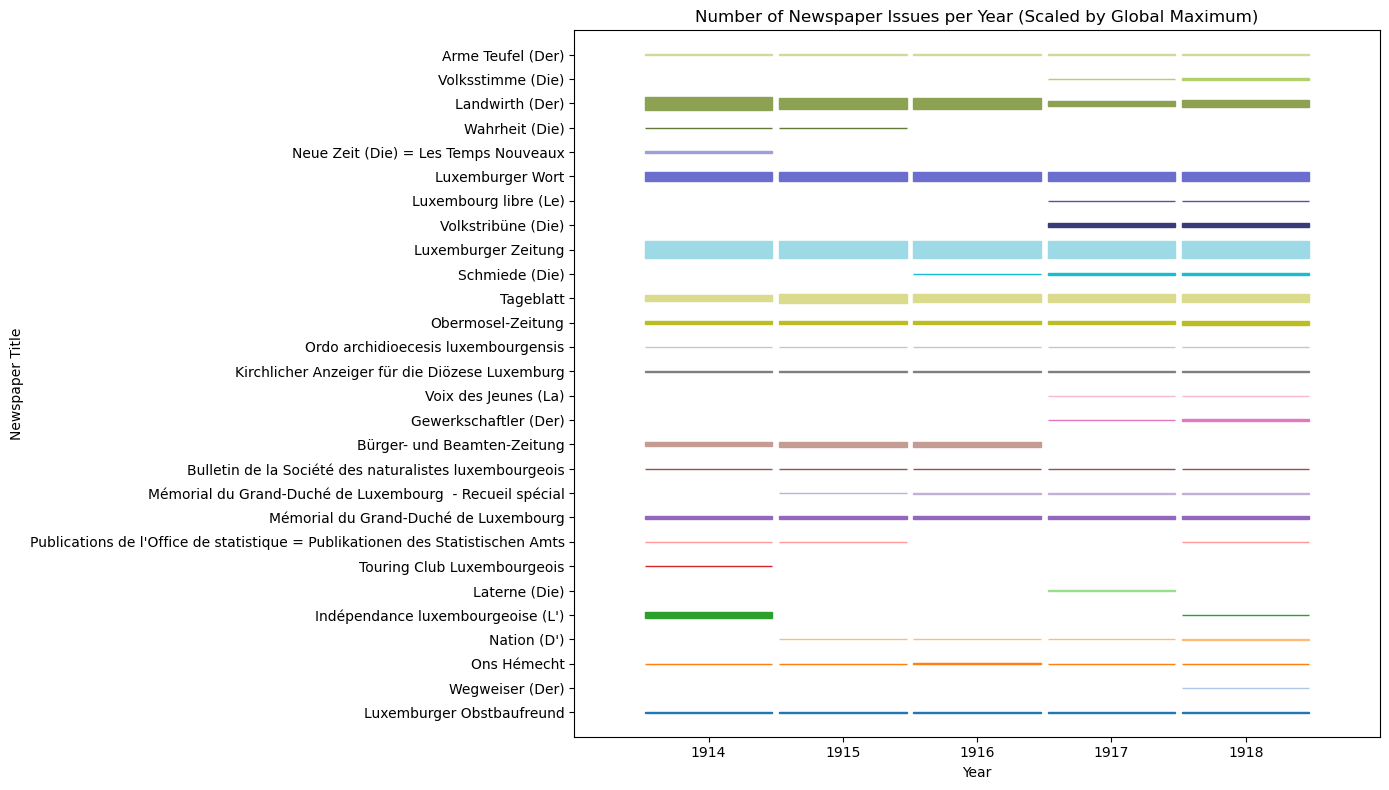

In [16]:
# ---- Prepare axes ----
series_names = list(newspaper_dict.keys())
all_years = sorted({year for series in newspaper_dict.values() for year in series})
global_max = max(value for series in newspaper_dict.values() for value in series.values())

fig, ax = plt.subplots(figsize=(14, 8))

# ---- Visual parameters ----
row_height = 0.8           # vertical space per series
max_box_height = 0.7       # maximum rectangle height
year_width = 0.95           # rectangle width

# ---- Build color palette (up to 60 colors) ----
palette = (
    list(plt.get_cmap("tab20").colors) +
    list(plt.get_cmap("tab20b").colors) +
    list(plt.get_cmap("tab20c").colors)
)

if len(series_names) > len(palette):
    raise ValueError("Too many series for the available color palette")

series_colors = {
    series: palette[i]
    for i, series in enumerate(series_names)
}

# ---- Draw rectangles ----
for y_idx, series in enumerate(series_names):
    y_center = y_idx
    color = series_colors[series]

    for year in all_years:
        value = newspaper_dict[series].get(year, 0)
        if value == 0:
            continue

        height = (value / global_max) * max_box_height

        rect = Rectangle(
            (year - year_width / 2, y_center - height / 2),
            year_width,
            height,
            facecolor=color,
            edgecolor=color
        )
        ax.add_patch(rect)

# ---- Formatting ----
ax.set_yticks(range(len(series_names)))
ax.set_yticklabels(series_names)
ax.set_xticks(all_years)
ax.set_xlabel("Year")
ax.set_ylabel("Newspaper Title")
ax.set_title("Number of Newspaper Issues per Year (Scaled by Global Maximum)")

ax.set_ylim(-1, len(series_names))
ax.set_xlim(min(all_years) - 1, max(all_years) + 1)

plt.tight_layout()
plt.savefig("plottingnewspaperdata.svg")